In [5]:
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('../src')

from base_sindy import GEM
import math

In [68]:
class K_Poly_Spline():

    def __init__(self, x, y, k=3, method=None, config=None) -> None:
        self.k = k
        self.x = x
        self.y = y
        self.len_x = len(x)
        self.method = method
        self.config = config

        self.b = np.zeros((k+1)*(len(y)-1))
        self.len_b = len(self.b)
        #self.b[:len(y)] = y

        self.A = np.zeros((len(self.b), len(self.b)))
        
        self.build_A_and_b()
        print('\t\tbuilt A and b. SIZE:', self.A.shape)
        #print(self.A)

        self.f = self.build_f_coefs()
        #print('found f coefs')

    def get_coef_values(self, x_i, derivative=0):
        coefs = np.zeros(self.k+1)
        for i, c in enumerate(coefs[:len(coefs)-derivative]):
            if i == self.k-derivative:
                c = math.factorial(self.k-i)/math.factorial(self.k-i-derivative)
            else:
                c = math.factorial(self.k-i)/math.factorial(self.k-i-derivative)*x_i**(self.k-i-derivative)
            coefs[i] = c
        return coefs

    def position_functions(self):
        matrix_i = 0
        matrix_j = 0
        for i, y_i in enumerate(self.y[:-1]):
            cs_1 = self.get_coef_values(self.x[i], derivative=0)
            cs_2 = self.get_coef_values(self.x[i+1], derivative=0)
            self.b[matrix_i:matrix_i+2] = [y_i, self.y[i+1]]
            for c in [cs_1, cs_2]:
                self.A[matrix_i, matrix_j:matrix_j+self.k+1] = c
                matrix_i += 1
            matrix_j += self.k+1
        return matrix_i

    def derivative_functions(self, matrix_i):
        for d in range(1,self.k):
            matrix_j = 0
            for i in range(1,self.len_x-1):
                cs = self.get_coef_values(self.x[i], d)
                cs_inv = -1*cs
                self.A[matrix_i, matrix_j:matrix_j+len(cs)*2] = list(cs)+list(cs_inv)
                matrix_i += 1
                matrix_j += len(cs)
        return matrix_i

    def edge_functions(self, matrix_i):
        num_dervs_needed = self.k//2
        c = 0
        for d in range(self.k-1, self.k-num_dervs_needed-1, -1):
            print(d)
            cs_0 = self.get_coef_values(self.x[0], d)
            cs_end = self.get_coef_values(self.x[-1], d)

            self.A[matrix_i, 0:self.k+1] = cs_0
            c+=1
            matrix_i +=1
            if c < self.k-1:
                self.A[matrix_i, self.len_b-len(cs_0):self.len_b] = cs_end
                c+=1
                matrix_i +=1
        return matrix_i


    def build_A_and_b(self):
        i = self.position_functions()
        print(i)
        i = self.derivative_functions(i)
        print(i)
        i = self.edge_functions(i)
        return

    def solve_A_b(self):
        self.A = np.asmatrix(self.A)
        self.b = np.asmatrix(self.b).T
        b = np.matmul(self.A.T, self.b)
        A = np.matmul(self.A.T, self.A)
        if self.config:
            config = self.config
        else:
            config = {'ridge_gm' : {'tol' : 1e-5}, 'ridge_cgm' : {'tol' : 1e-5}, 'ridge_jor' : {'tol' : 1e-5}}
        if self.method == 'GEM':
            return GEM(A, b)
        elif self.method == 'GM':
            x, results = gradient_method(A, b, np.zeros(len(b))+1, **config['ridge_gm'])
            return x
        elif self.method == 'CGM':
            x, results = conj_gradient_method(A, b, np.zeros(len(b))+1, **config['ridge_cgm'])
        elif self.method == 'rref':
            return rref(A, b)
        elif self.method == 'JOR':
            x, results = JOR(A, b, np.zeros(len(b))+1, **config['ridge_jor'])
            return x
        elif self.method == 'inv':
            return np.matmul(np.linalg.inv(A), b)
        else:
            return np.linalg.solve(A, b)

    def build_f_coefs(self):
        #print('solving A b...')
        coefs = self.solve_A_b()
        #print('solved.')
        coef_dict = {}
        i = 0
        for x in self.x[1:]:
            coef_dict[x] = np.array(coefs[i:i+self.k+1])
            i += self.k+1

        return coef_dict

    def get_pred_y(self, x_s, derivative=0):
        keys = list(self.f.keys())
        #print(x_s)
        
        if x_s >= self.x[0] and x_s <= self.x[-1]:
            if x_s <= keys[0]:
                res = keys[0]
            else:
                for i, x in enumerate(keys[:-1]):
                    if x_s >= x and x_s <= keys[i+1]:
                        break
                #print(i, '\n')
                res = keys[i+1]
        else:
            print('x_s is out of predictable range, returning np.nan')
            return np.nan
        
        if derivative >= 0 and derivative < self.k:
            c = np.array(self.get_coef_values(x_s, derivative=derivative))
            # print(c)
            # print(self.f[res])
            # print()
            return np.sum(c*self.f[res])
        else:
            print('derivative too high or does not make sense. returning None')
            return np.nan

    def interpolate(self, list_x, derivative=0):
        return np.array([self.get_pred_y(x, derivative=derivative) for x in list_x])

In [69]:
x = [0,1,2,3,4]
y = [21,24,24,18,16]

In [78]:
spline = K_Poly_Spline(x,y, k=5, method='GEM')

8
20
4
3
		built A and b. SIZE: (24, 24)


In [79]:
print(spline.A)

[[ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  1.000e+00
   0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 1.000e+00  1.000e+00  1.000e+00  1.000e+00  1.000e+00  1.000e+00
   0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
   1.000e+00  1.000e+00  1.000e+00  1.000e+00  1.000e+00  1.000e+00
   0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
   3.200e+01  1.600e+01  8.000e+00  4.000e+00  2.000e+00  1.000e+00
   0.000e+00  0.000e+00  0.000e+00  0.000e+00

In [80]:
x_s = np.linspace(x[0], x[-1], 100)
y_s = spline.interpolate(x_s, 0)

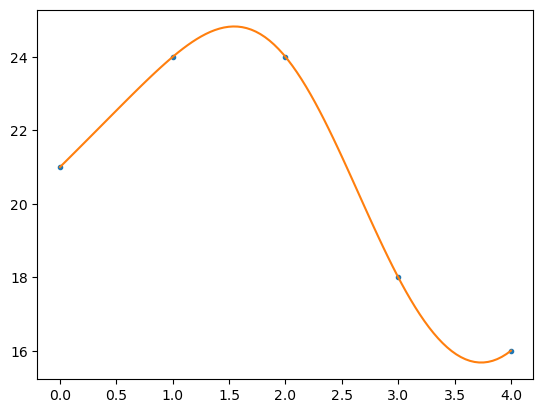

In [81]:
plt.plot(x,y, '.')
plt.plot(x_s, y_s)
plt.show()